# MatrixFactorization Alternating-Least-Squares

In [7]:
import utils
import pickle
import numpy as np
from tqdm.auto import tqdm
import scipy.sparse
import matplotlib.pyplot as plt
# from recommenders.mf import MatrixFactorization
%matplotlib inline

In [2]:
cui = scipy.sparse.load_npz('./data/cui.npz')
# y = scipy.sparse.load_npz('./data/test.npz')
# _y = y.tocsr()

In [3]:
# cui.count_nonzero()

In [4]:
# import pyximport
# pyximport.install(reload_support=True)
# import _als

## Alternating Least Squares recommender

In [2]:
def nonzeros(m, row):
    """returns the non zeroes of a row in csr_matrix"""
    for index in range(m.indptr[row], m.indptr[row + 1]):
        yield m.indices[index], m.data[index]

    
def user_linear_equation(Y, YtY, Cui, u, regularization, n_factors):
    # Xu = (YtCuY + regularization * I)^-1 (YtCuPu)
    # YtCuY = YtY + Yt(Cu-I)Y
    # YtCuY + regularization * I = YtY regularization * I + Yt(Cu-I)Y

    # accumulate YtCuY + regularization*I in A
    A = YtY + regularization * np.eye(n_factors)

    # accumulate YtCuPu in b
    b = np.zeros(n_factors)

    for i, confidence in nonzeros(Cui, u):
        factor = Y[i]

        if confidence > 0:
            b += confidence * factor
        else:
            confidence *= -1

        A += (confidence - 1) * np.outer(factor, factor)
    return A, b


def user_factor(Y, YtY, Cui, u, regularization, n_factors):
    # Xu = (YtCuY + regularization * I)^-1 (YtCuPu)
    A, b = user_linear_equation(Y, YtY, Cui, u, regularization, n_factors)
    return np.linalg.solve(A, b)


def item_factor(X, XtX, Cui, u, regularization, n_factors):
    # Yu = (XtCuX + regularization * I)^-1 (XtCuPu)
    A, b = user_linear_equation(X, XtX, Cui, u, regularization, n_factors)
    return np.linalg.solve(A, b)


def least_squares(Cui, X, Y, regularization, num_threads=0):
    """For each user in Cui, calculate factors Xu for them using least squares on Y"""
    users, n_factors = X.shape
    YtY = Y.T.dot(Y)
    for u in range(users):
        X[u] = user_factor(Y, YtY, Cui, u, regularization, n_factors)


In [3]:
import _als

class AlternatingLeastSquares:
    """
    Alternating Least Squares
    A Recommender based on the algorithms described in the paper 'Collaborative
    Filtering for Implicit Feedback Datasets'    

    Args:
        K: number of latent factors
        regularization: regularization parameter
        iterations: number of training iterations to perform
        num_threads: number of threads to use for fitting. 0 means to use the number of cores on the machine
        seed: random seed
      
    Attribs:
        item_factors (numpy.ndarray): Array of latent factors for each item in the training set
        user_factors (numpy.ndarray): Array of latent factors for each user in the training set
    """
    
    
    def __init__(self, K=100, regularization=0.01, iterations=10, num_threads=0, seed=None):
        self.K = K
        self.regularization = regularization
        self.iterations = iterations
        self.random_state = np.random.RandomState(seed)
        self.num_threads = num_threads
        
        # learned factors
        self.item_factors = None
        self.user_factors = None
        
        # cache of user, item norms (useful for calculating similar items)
        self._user_norms = None
        self._item_norms = None
        
        # cache for item factors squared
        self._YtY = None
        # cache for user factors squared
        self._XtX = None
        

    @property
    def YtY(self):
        if self._YtY is None:
            Y = self.item_factors
            self._YtY = Y.T.dot(Y)
        return self._YtY
    
    
    @property
    def XtX(self):
        if self._XtX is None:
            X = self.user_factors
            self._XtX = X.T.dot(X)
        return self._XtX
    
    
    def calculate_loss(self, Cui, X, Y, regularization):
        indptr = np.array(Cui.indptr)
        indices = np.array(Cui.indices)
        data = np.array(Cui.data)
        return _als.calculate_loss(indptr, indices, data, X, Y, regularization)


    def train(self, x, y, show_progress=True):
        """Factorizes the item_users matrix.
        
        The user-item matrix x defines which items are liked by which users (P_iu in the original paper), 
        as well as how much confidence we have that the user liked the item (C_iu).
        The positive items (rating > 2.5) are defined with a positive C_ui, 
        the negative items (rating < 2.5 ) are defined with a negative C_ui.
        Unseen items (rating 0) are defined with negative C_ui = -2.
        items without a rating are implicitly defined with C_ui = -1 but are not stored in the matrix.

        Args:
            x (scipy.sparse.csr_matrix): 
                Matrix of confidences for the liked items. This matrix should be a csr_matrix where
                the rows of the matrix are the user, the columns are the item that the user liked,
                and the value is the confidence that the user liked the item.
            seed (int): 
                The random seed to use
            show_progress (bool):
                Whether to show a progress bar during fitting
        
        Returns:
            mse (List[int]): 
                The training mean square error of each training iteration
        """
        if not isinstance(x, scipy.sparse.csr_matrix):
            x = x.tocsr()
        if not isinstance(y, scipy.sparse.csr_matrix):
            y = y.tocsr()
            
        # Initialize the variables randomly if they haven't already been set
        users, items = x.shape

        if self.user_factors is None:
            self.user_factors = self.random_state.rand(users, self.K).astype(np.float64) * 0.01
        if self.item_factors is None:
            self.item_factors = self.random_state.rand(items, self.K).astype(np.float64) * 0.01
        
        # invalidate cached norms and squared factors
        self._item_norms = None
        self._user_norms = None
        self._YtY = None
        self._XtX = None
               
        train_mse = []
        test_mse = []
        
        tst = self.calculate_loss(x,
                                  self.user_factors,
                                  self.item_factors,
                                  self.regularization)
        
        with tqdm(total=self.iterations, disable=not show_progress) as progress:
            # alternate between learning the user_factors from the item_factors and vice-versa
            for iteration in range(self.iterations):
                least_squares(
                    x,
                    self.user_factors,
                    self.item_factors,
                    self.regularization
                )
                least_squares(
                    x,
                    self.item_factors,
                    self.user_factors,
                    self.regularization
                )
                progress.update(1)
                train_error = self.calculate_loss(
                        x,
                        self.user_factors,
                        self.item_factors,
                        self.regularization)
                test_error = self.calculate_loss(
                        y,
                        self.user_factors,
                        self.item_factors,
                        self.regularization)
                train_mse.append(train_error)
                test_mse.append(test_error)
                progress.set_postfix(test_error=test_error, train_error=train_error)
        
        return train_mse, test_mse


    def recommend(self, user, k, oldrecs):
        user_factors = self.user_factors[user]
        scores = self.item_factors.dot(user_factors)
        # sort items in descending order by their score
        ind = np.argsort(scores)[::-1]
        # remove consumed items, i.e. items from training set
        consumed = np.array(old_recs.getrow(user).nonzero()[1])
        ind = np.setdiff1d(ind, consumed, assume_unique=True)
        # take top-k
        return ind[:k]
    
 
    def save(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self, f)


    def load(self, path):
        with open(path, 'rb') as f:
            m = pickle.load(f)
            self.K = m.K
            self.regularization = m.regularization
            self.iterations = m.iterations

## Train-test split

- For validation we do 5 random 80%/20% train-test splits
- for each of the 5 random splits we use agreed seeds, i.e. {1,2,3,4,5}
- For each train-test pair:
  - Perform hyperparameter optimisation on the train part (via cross-validation) 
  - Evaluate on the test part.
 - This gives us 5 (recall@10, ndcg@10) tuples for which we compute the mean and stdev.

In [72]:
def create_train_test_split(cui, test_size=0.20, seed=1):
    m = cui.tolil()
    train_rows = np.empty_like(m.rows)
    test_rows = np.empty_like(m.rows)
    train_data = np.empty_like(m.rows)
    test_data = np.empty_like(m.rows)
    random_state = np.random.RandomState(seed)
    for row in range(m.shape[0]):
        columns = np.array(m.rows[row])
        nr_cols = columns.shape[0]
        all_indices = np.arange(nr_cols)
        test_indices = random_state.choice(all_indices, size=int(test_size * nr_cols), replace=False)
        train_indices = np.setdiff1d(all_indices, test_indices, assume_unique=True)
        train_rows[row] = np.array(m.rows[row])[train_indices].tolist()
        test_rows[row] = np.array(m.rows[row])[test_indices].tolist()
        train_data[row] = np.array(m.data[row])[train_indices].tolist()
        test_data[row] = np.array(m.data[row])[test_indices].tolist()
    train_lil = m.copy()
    train_lil.rows = train_rows
    train_lil.data = train_data
    test_lil = m.copy()
    test_lil.rows = test_rows
    test_lil.data = test_data
    return train_lil.tocsr(), test_lil.tocsr()

In [73]:
import numpy as np
from sklearn.model_selection import train_test_split

outer_loops = 5 # nr. of random train-test splits
traintest_list = []
for i in tqdm(range(outer_loops)):
    seed = i + 1
    # cui is of type scipy.sparse.coo_matrix
    # x and y are of type scipy.sparse.csr_matrix
    train, test = create_train_test_split(cui, test_size=0.20, seed=seed)
    scipy.sparse.save_npz(f'./data/train_{seed}.npz', train)
    scipy.sparse.save_npz(f'./data/test_{seed}.npz', test)
    traintest_list.append((train, test, seed))


  0%|          | 0/5 [00:00<?, ?it/s]

## Training

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

outer_loops = 1 #5 # nr. of random train-test splits
recall_list = []
ndgc_list = []
e_train_list = []
e_test_list = []
for i in range(outer_loops):
    seed = i + 1
    x = scipy.sparse.load_npz(f'./data/train_{seed}.npz')
    y = scipy.sparse.load_npz(f'./data/test_{seed}.npz')
    # x and y are of type scipy.sparse.csr_matrix
    recommender = AlternatingLeastSquares(K=10, regularization=0.01, iterations=10, seed=seed)
    e_train, e_test = recommender.train(x, y)
    e_train_list.append(e_train)
    e_test_list.append(e_test)

  0%|          | 0/10 [00:00<?, ?it/s]

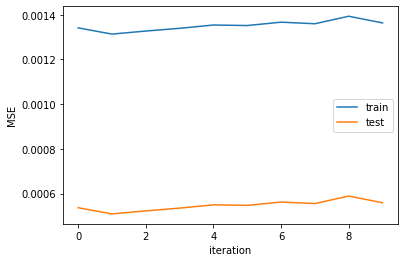

In [8]:
e_train, e_test = e_train_list[0], e_test_list[0]
plt.plot(e_train, label="train")
plt.plot(e_test, label="test")
plt.xlabel("iteration")
plt.ylabel("MSE")
plt.legend()
plt.show()
recommender.save("checkpoint.model")

## Confidence based recommendations

In [13]:
def recommend(rec, user, k, oldrecs):
    user_factors = rec.user_factors[user]
    scores = rec.item_factors.dot(user_factors)
    # sort items in descending order by their score
    ind = np.argsort(scores)[::-1]
    # remove consumed items, i.e. items from training set
    consumed = np.array(oldrecs.getrow(user).nonzero()[1])
    ind = np.setdiff1d(ind, consumed, assume_unique=True)
    # take top-k
    return ind[:k]

In [14]:
seed = 1
x = scipy.sparse.load_npz(f'./data/train_{seed}.npz')
y = scipy.sparse.load_npz(f'./data/test_{seed}.npz')

In [17]:
precision_scores = []
recall_scores = []
ndcg_scores = []
K = 10
for i in tqdm(range(y.shape[0])):
    topk = recommend(recommender, user=i, k=K, oldrecs=x)
    actual = y[i]
    precision_scores.append(utils.precision_at_k(topk, actual))
    recall_scores.append(utils.recall_at_k(topk, actual))
    ndcg_scores.append(utils.ndcg_at_k(topk, actual))
print(f'AVG. PRECISION@{K}: ', np.mean(precision_scores))
print(f'AVG. RECALL@{K}: ', np.mean(recall_scores))
print(f'AVG. NDCG@{K}: ', np.mean(ndcg_scores))

  0%|          | 0/148438 [00:00<?, ?it/s]

AVG. PRECISION@10:  0.0005288403239062775
AVG. RECALL@10:  0.00045364159415135964
AVG. NDCG@10:  0.003622711232155607
